In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

# scikit-learn
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn import metrics

In [2]:
print(xgboost.__version__)

In [3]:
# 特徴量（広告費）を作成
x = np.array([20, 30, 100, 120, 220, 240])
x = x[:, None].astype('float64')

In [4]:
# ターゲット（売上）作成
y = np.array([10, 30, 120, 110, 80, 70])
y = y[:, None].astype('float64')

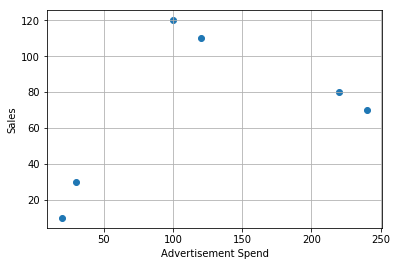

In [5]:
# 特徴量とターゲットをプロット
plt.scatter(x, y, marker='o')
plt.xlabel("Advertisement Spend")
plt.ylabel("Sales")
plt.grid(True)
plt.show()

In [6]:
# ステージ１の推測値（平均値としておく）
y_mean = np.full((6, 1), y.mean())
M1_pred = y_mean.copy()

In [7]:
y_mean, M1_pred

(array([[70.],
        [70.],
        [70.],
        [70.],
        [70.],
        [70.]]), array([[70.],
        [70.],
        [70.],
        [70.],
        [70.],
        [70.]]))

In [8]:
# ステージ１の残差
error_1 = y - y_mean
error_1

array([[-60.],
       [-40.],
       [ 50.],
       [ 40.],
       [ 10.],
       [  0.]])

In [9]:
# ステージ１の確認
table = pd.DataFrame({
    '広告費':x[:, 0],
    '売上':y[:, 0],
    'M1推測':M1_pred[:, 0],
    'M1残差':error_1[:, 0]},
    index=["A", "B", "C", "D", "E", "F"]
)
table.loc[:, :]

,広告費,売上,M1推測,M1残差
A,20.0,10.0,70.0,-60.0
B,30.0,30.0,70.0,-40.0
C,100.0,120.0,70.0,50.0
D,120.0,110.0,70.0,40.0
E,220.0,80.0,70.0,10.0
F,240.0,70.0,70.0,0.0


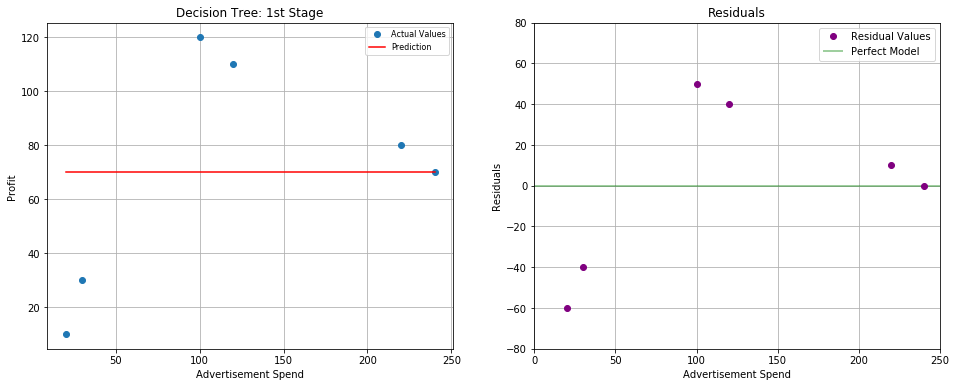

In [10]:
# ステージ１可視化
# 予測
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))
ax1.plot(x, y, 'o', label='Actual Values')
ax1.plot(x, M1_pred, 'r', label='Prediction')
ax1.set_title('Decision Tree: 1st Stage')
ax1.set_xlabel('Advertisement Spend')
ax1.set_ylabel('Profit')
ax1.grid(True)
ax1.legend(fontsize=8)

# 残差
ax2.plot(x, error_1, 'o', color='purple', label='Residual Values')
ax2.set_xlim(0, 250)
ax2.set_ylim(-80, 80)
ax2.hlines(y=0, xmin=0, xmax=360, color='g', alpha=0.5, label='Perfect Model')
ax2.set_title('Residuals')
ax2.set_xlabel('Advertisement Spend')
ax2.set_ylabel('Residuals')
ax2.grid(True)
ax2.legend()

In [11]:
# ステージ２のモデル構築
# 決定木
model_2 = DecisionTreeRegressor(max_depth=1)
# 特徴量:広告費 (x)、ターゲット：ステージ１の残差(error_1)
model_2 = model_2.fit(x, error_1)
# 予測（前の層の誤差を予測）
model_2_output = model_2.predict(x)

In [12]:
# ステージ１の推測値（売上）とステージ２の推測値（M1の誤差）を
# 加算したものを、ステージ２の推測値（売上）とする。
M2_pred = M1_pred + model_2_output.reshape(-1, 1)
M2_pred

array([[20.],
       [20.],
       [95.],
       [95.],
       [95.],
       [95.]])

In [13]:
# ステージ２の残差
error_2 = y - M2_pred
error_2

array([[-10.],
       [ 10.],
       [ 25.],
       [ 15.],
       [-15.],
       [-25.]])

In [14]:
# ステージ２の確認
stage_2 = pd.DataFrame({
    'M2出力': model_2_output.reshape(-1, 1)[:, 0],
    'M2推測': M2_pred[:, 0],
    'M2残差': error_2[:, 0]},
    index=["A", "B", "C", "D", "E", "F"]
)

stage_2 = pd.concat([table, stage_2], axis=1)
stage_2.loc[:, :]

,広告費,売上,M1推測,M1残差,M2出力,M2推測,M2残差
A,20.0,10.0,70.0,-60.0,-50.0,20.0,-10.0
B,30.0,30.0,70.0,-40.0,-50.0,20.0,10.0
C,100.0,120.0,70.0,50.0,25.0,95.0,25.0
D,120.0,110.0,70.0,40.0,25.0,95.0,15.0
E,220.0,80.0,70.0,10.0,25.0,95.0,-15.0
F,240.0,70.0,70.0,0.0,25.0,95.0,-25.0


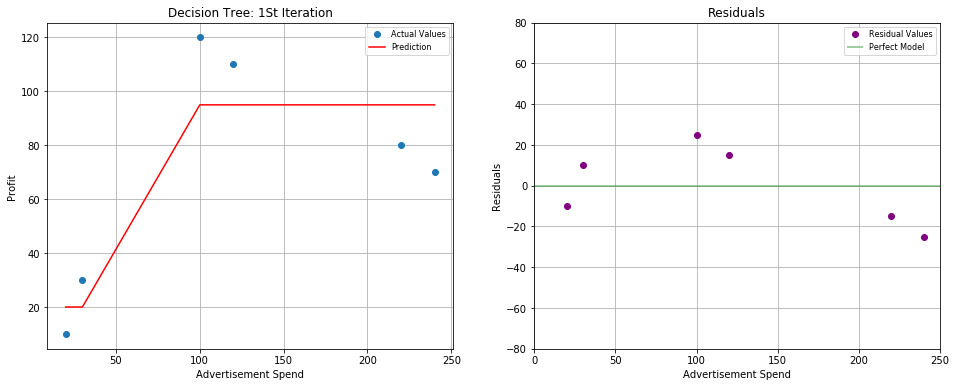

In [15]:
# ステージ２の結果
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))

# 予測のプロット
ax1.plot(x, y, 'o', label='Actual Values')
ax1.plot(x, M2_pred, 'r', label='Prediction')
ax1.set_title('Decision Tree: 1St Iteration')
ax1.set_xlabel('Advertisement Spend')
ax1.set_ylabel('Profit')
ax1.grid(True)
ax1.legend(fontsize=8)

# 誤差のプロット
ax2.plot(x, error_2, 'o', color='purple', label='Residual Values')
ax2.set_xlim(0, 250)
ax2.set_ylim(-80, 80)
ax2.hlines(y=0, xmin=0, xmax=300, color='g', alpha=0.5, label='Perfect Model')
ax2.set_title('Residuals')
ax2.set_xlabel('Advertisement Spend')
ax2.set_ylabel('Residuals')
ax2.grid(True)
ax2.legend(fontsize=8)

In [16]:
# 特徴量を 6個から 300個にしてみる
x_mock = np.linspace(0, 299, 300).reshape(-1, 1)

# x_mock を入力にして予測
model_2_output_mock = model_2.predict(x_mock)
M1_pred_mock = np.full((300, 1), M1_pred.mean())
M2_pred_mock = M1_pred_mock + model_2_output_mock.reshape(-1, 1)

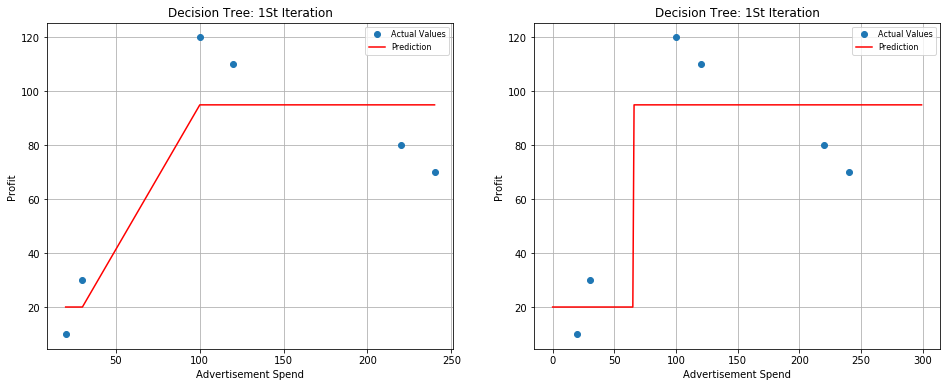

In [17]:
# ステージ２の結果
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))

# 予測のプロット
ax1.plot(x, y, 'o', label='Actual Values')
ax1.plot(x, M2_pred, 'r', label='Prediction')
ax1.set_title('Decision Tree: 1St Iteration')
ax1.set_xlabel('Advertisement Spend')
ax1.set_ylabel('Profit')
ax1.grid(True)
ax1.legend(fontsize=8)

# 水増しデータのプロット
ax2.plot(x, y, 'o', label='Actual Values')
ax2.plot(x_mock, M2_pred_mock, 'r', label='Prediction')
ax2.set_title('Decision Tree: 1St Iteration')
ax2.set_xlabel('Advertisement Spend')
ax2.set_ylabel('Profit')
ax2.grid(True)
ax2.legend(fontsize=8)


In [18]:
# ステージ３のモデル構築
model_3 = DecisionTreeRegressor(max_depth=1)
model_3 = model_3.fit(x, error_2)
model_3_output = model_3.predict(x)

In [19]:
# ステージ３の推測値
M3_pred = M2_pred + model_3_output.reshape(-1, 1)

# ステージ３の残差
error_3 = y - M3_pred

In [20]:
# ステージ３の確認
stage_3 = pd.DataFrame({
    'M3出力': model_3_output.reshape(-1, 1)[:, 0],
    'M3推測': M3_pred[:, 0],
    'M3残差': error_3[:, 0]},
    index=["A", "B", "C", "D", "E", "F"]
)

stage_3 = pd.concat([stage_2, stage_3], axis=1)

stage_3.loc[:, :]

,広告費,売上,M1推測,M1残差,M2出力,M2推測,M2残差,M3出力,M3推測,M3残差
A,20.0,10.0,70.0,-60.0,-50.0,20.0,-10.0,10.0,30.0,-20.0
B,30.0,30.0,70.0,-40.0,-50.0,20.0,10.0,10.0,30.0,0.0
C,100.0,120.0,70.0,50.0,25.0,95.0,25.0,10.0,105.0,15.0
D,120.0,110.0,70.0,40.0,25.0,95.0,15.0,10.0,105.0,5.0
E,220.0,80.0,70.0,10.0,25.0,95.0,-15.0,-20.0,75.0,5.0
F,240.0,70.0,70.0,0.0,25.0,95.0,-25.0,-20.0,75.0,-5.0


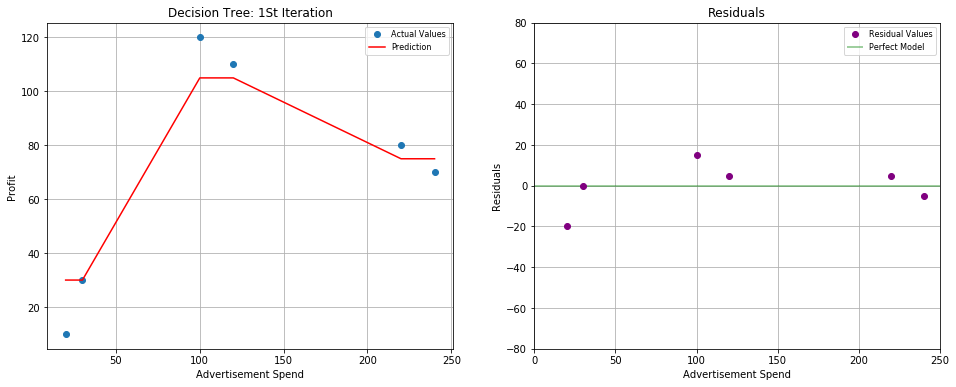

In [21]:
# ステージ３の結果
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))

# 予測のプロット
ax1.plot(x, y, 'o', label='Actual Values')
ax1.plot(x, M3_pred, 'r', label='Prediction')
ax1.set_title('Decision Tree: 1St Iteration')
ax1.set_xlabel('Advertisement Spend')
ax1.set_ylabel('Profit')
ax1.grid(True)
ax1.legend(fontsize=8)

# 誤差のプロット
ax2.plot(x, error_3, 'o', color='purple', label='Residual Values')
ax2.set_xlim(0, 250)
ax2.set_ylim(-80, 80)
ax2.hlines(y=0, xmin=0, xmax=300, color='g', alpha=0.5, label='Perfect Model')
ax2.set_title('Residuals')
ax2.set_xlabel('Advertisement Spend')
ax2.set_ylabel('Residuals')
ax2.grid(True)
ax2.legend(fontsize=8)

In [22]:
# 特徴量を 6個から 300個にしてみる
# x_mock を入力にして予測
model_3_output_mock = model_3.predict(x_mock)
M3_pred_mock = M2_pred_mock + model_3_output_mock.reshape(-1, 1)

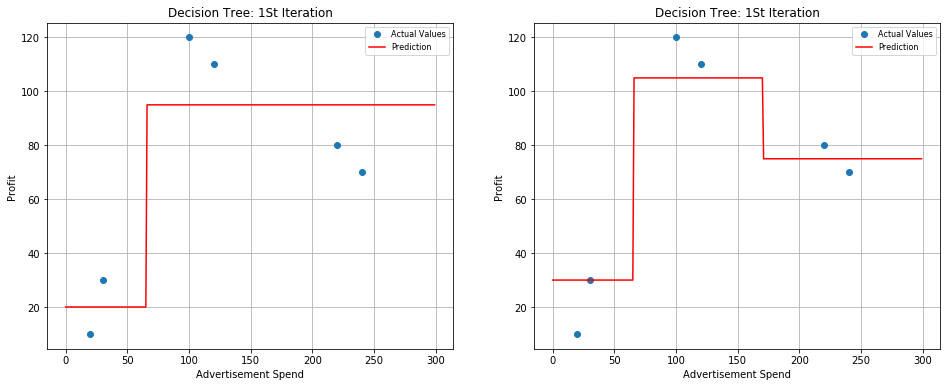

In [23]:
# ステージ３の結果
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))

# ステージ２の水増しプロット
ax1.plot(x, y, 'o', label='Actual Values')
ax1.plot(x_mock, M2_pred_mock, 'r', label='Prediction')
ax1.set_title('Decision Tree: 1St Iteration')
ax1.set_xlabel('Advertisement Spend')
ax1.set_ylabel('Profit')
ax1.grid(True)
ax1.legend(fontsize=8)

# ステージ３の水増しデータのプロット
ax2.plot(x, y, 'o', label='Actual Values')
ax2.plot(x_mock, M3_pred_mock, 'r', label='Prediction')
ax2.set_title('Decision Tree: 1St Iteration')
ax2.set_xlabel('Advertisement Spend')
ax2.set_ylabel('Profit')
ax2.grid(True)
ax2.legend(fontsize=8)


In [24]:
# ステージ４のモデル構築
model_4 = DecisionTreeRegressor(max_depth=1)
model_4 = model_4.fit(x, error_3)
model_4_output = model_4.predict(x)

In [25]:
# ステージ４の推測値
M4_pred = M3_pred + model_4_output.reshape(-1, 1)

# ステージ４の残差
error_4 = y - M4_pred

In [26]:
# ステージ４の確認
stage_4 = pd.DataFrame({
    'M4出力': model_4_output.reshape(-1, 1)[:, 0],
    'M4推測': M4_pred[:, 0],
    'M4残差': error_4[:, 0]},
    index=["A", "B", "C", "D", "E", "F"]
)

stage_4 = pd.concat([stage_3, stage_4], axis=1)

stage_4.loc[:, :]

,広告費,売上,M1推測,M1残差,M2出力,M2推測,M2残差,M3出力,M3推測,M3残差,M4出力,M4推測,M4残差
A,20.0,10.0,70.0,-60.0,-50.0,20.0,-10.0,10.0,30.0,-20.0,-20.0,10.0,0.0
B,30.0,30.0,70.0,-40.0,-50.0,20.0,10.0,10.0,30.0,0.0,4.0,34.0,-4.0
C,100.0,120.0,70.0,50.0,25.0,95.0,25.0,10.0,105.0,15.0,4.0,109.0,11.0
D,120.0,110.0,70.0,40.0,25.0,95.0,15.0,10.0,105.0,5.0,4.0,109.0,1.0
E,220.0,80.0,70.0,10.0,25.0,95.0,-15.0,-20.0,75.0,5.0,4.0,79.0,1.0
F,240.0,70.0,70.0,0.0,25.0,95.0,-25.0,-20.0,75.0,-5.0,4.0,79.0,-9.0


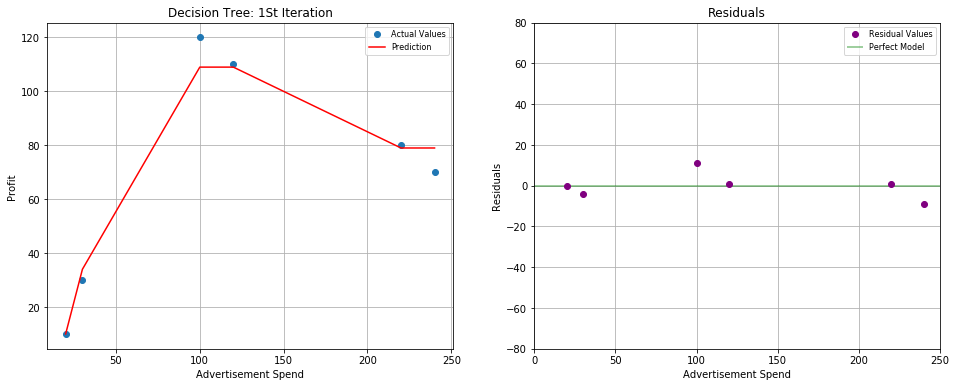

In [27]:
# ステージ４の結果
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))

# 予測のプロット
ax1.plot(x, y, 'o', label='Actual Values')
ax1.plot(x, M4_pred, 'r', label='Prediction')
ax1.set_title('Decision Tree: 1St Iteration')
ax1.set_xlabel('Advertisement Spend')
ax1.set_ylabel('Profit')
ax1.grid(True)
ax1.legend(fontsize=8)

# 誤差のプロット
ax2.plot(x, error_4, 'o', color='purple', label='Residual Values')
ax2.set_xlim(0, 250)
ax2.set_ylim(-80, 80)
ax2.hlines(y=0, xmin=0, xmax=300, color='g', alpha=0.5, label='Perfect Model')
ax2.set_title('Residuals')
ax2.set_xlabel('Advertisement Spend')
ax2.set_ylabel('Residuals')
ax2.grid(True)
ax2.legend(fontsize=8)

In [28]:
# 特徴量を 6個から 300個にしてみる
# x_mock を入力にして予測
model_4_output_mock = model_4.predict(x_mock)
M4_pred_mock = M3_pred_mock + model_4_output_mock.reshape(-1, 1)

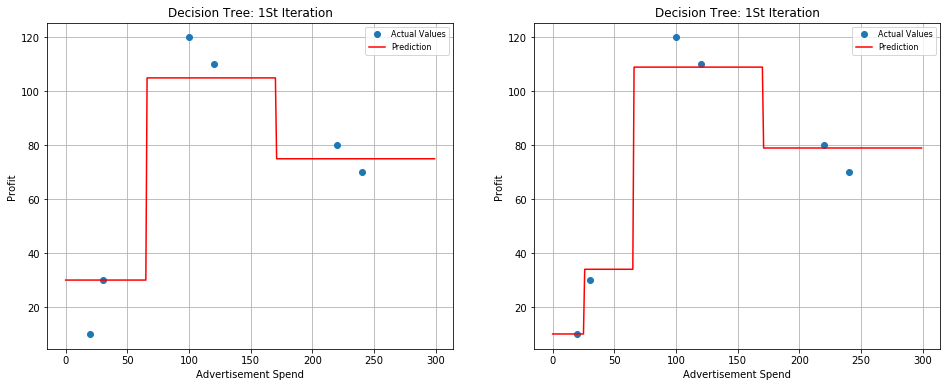

In [29]:
# ステージ４の結果
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))

# ステージ３の水増しプロット
ax1.plot(x, y, 'o', label='Actual Values')
ax1.plot(x_mock, M3_pred_mock, 'r', label='Prediction')
ax1.set_title('Decision Tree: 1St Iteration')
ax1.set_xlabel('Advertisement Spend')
ax1.set_ylabel('Profit')
ax1.grid(True)
ax1.legend(fontsize=8)

# ステージ４の水増しデータのプロット
ax2.plot(x, y, 'o', label='Actual Values')
ax2.plot(x_mock, M4_pred_mock, 'r', label='Prediction')
ax2.set_title('Decision Tree: 1St Iteration')
ax2.set_xlabel('Advertisement Spend')
ax2.set_ylabel('Profit')
ax2.grid(True)
ax2.legend(fontsize=8)


In [30]:
# データを拡張して確認

In [31]:
# 特徴量
x = pd.DataFrame({'x': np.arange(0, 100)})

# ターゲット
y1 = np.random.uniform(0, 9, 20)
y2 = np.random.uniform(20, 22, 20)
y3 = np.random.uniform(16, 19, 20)
y4 = np.random.uniform(5, 17, 20)
y5 = np.random.uniform(11, 18, 20)

y = np.concatenate((y1, y2, y3, y4, y5)).reshape(-1, 1)

In [32]:
x.shape, y.shape

((100, 1), (100, 1))

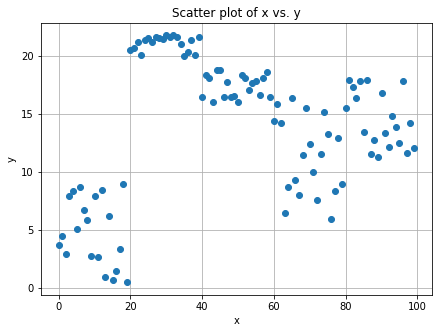

In [33]:
# 散布図
plt.figure(figsize=(7, 5))
plt.plot(x, y, 'o')
plt.title('Scatter plot of x vs. y')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

In [36]:
# データサイズ
n = len(y)

# 推測値を初期化（とりあえず平均）
y_pred_i = np.full((n, 1), y.mean())


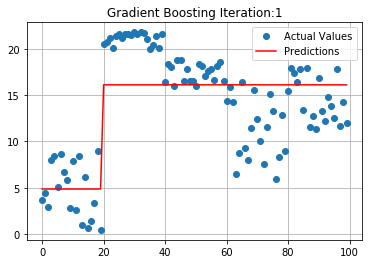

MSE: 15.607113644912921


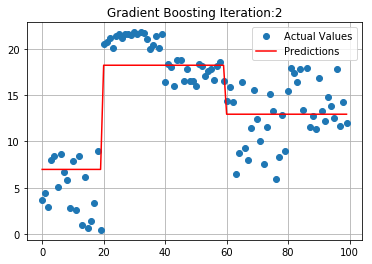

MSE: 8.886547169087542


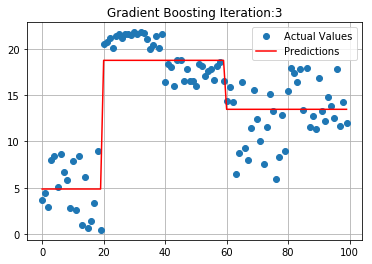

MSE: 7.76645275644998


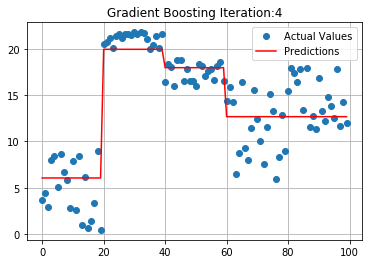

MSE: 6.820621678398058


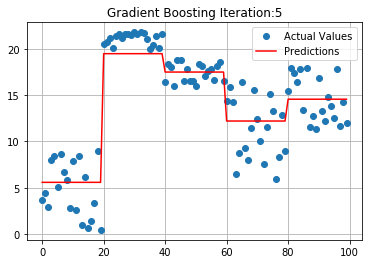

MSE: 5.930897582673278


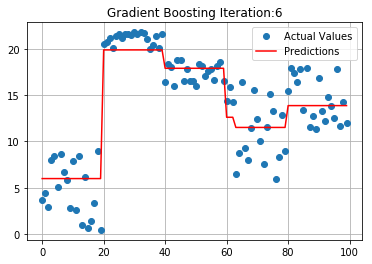

MSE: 5.649739700620613


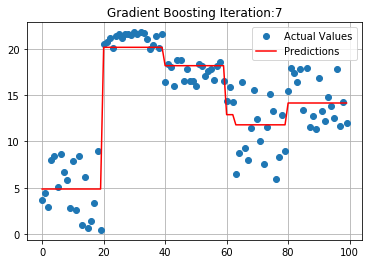

MSE: 5.332860395784188


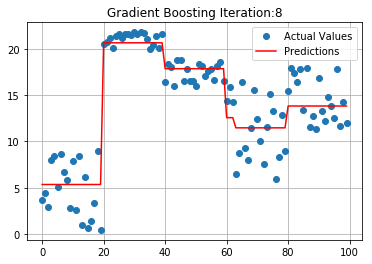

MSE: 5.174448189708216


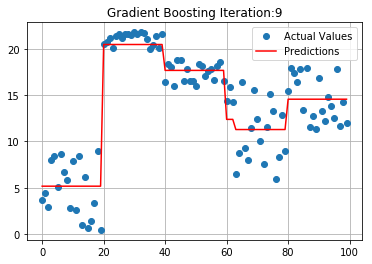

MSE: 5.0392390819091135


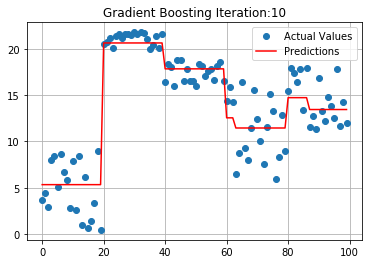

MSE: 4.853359817148044


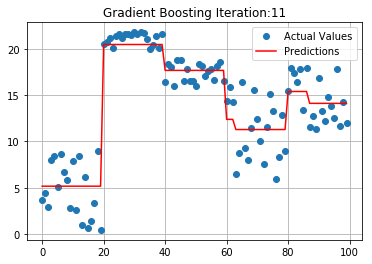

MSE: 4.742259566946023


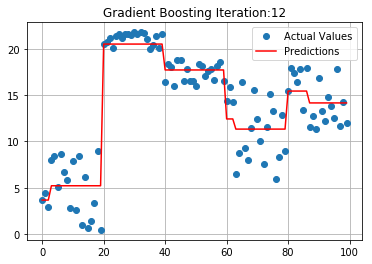

MSE: 4.672730003475561


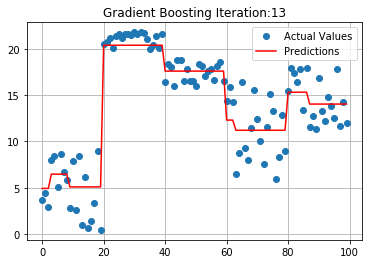

MSE: 4.516472633950262


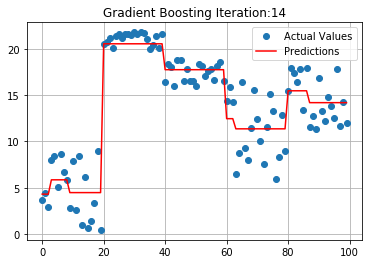

MSE: 4.421801208649254


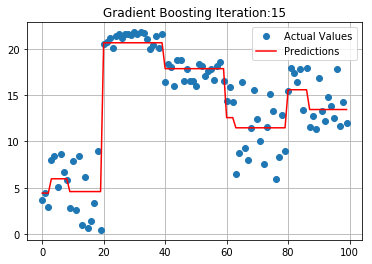

MSE: 4.339414155209846


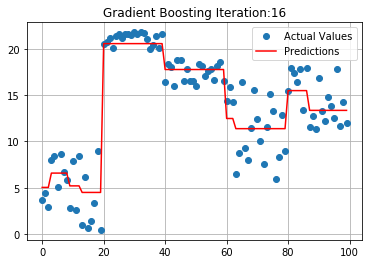

MSE: 4.282757518132743


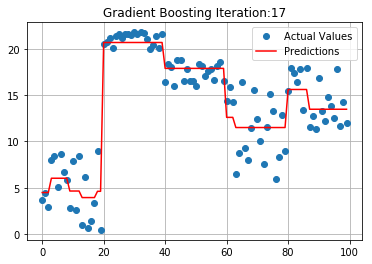

MSE: 4.214994592084623


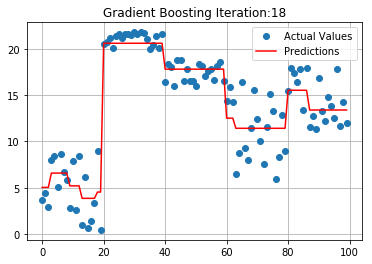

MSE: 4.1688673384656605


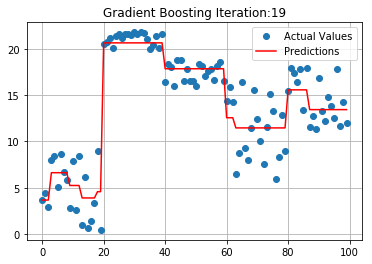

MSE: 4.110963132171026


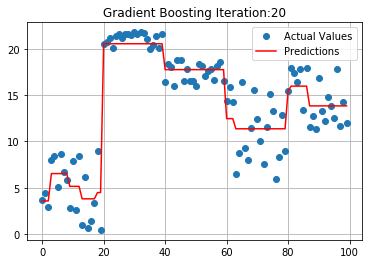

MSE: 4.072975005505887


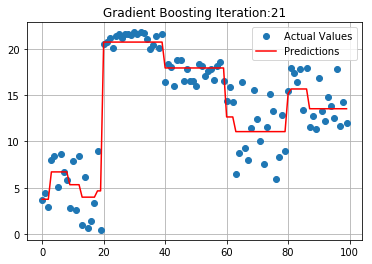

MSE: 4.0178046817758455


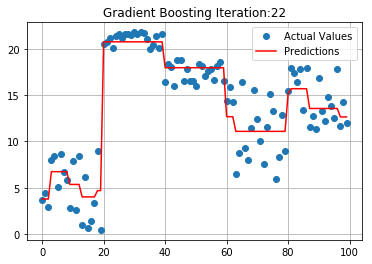

MSE: 3.9934696552401006


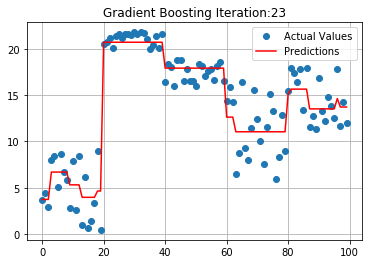

MSE: 3.945631300825407


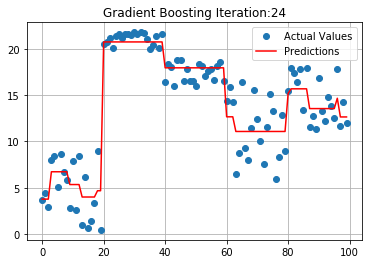

MSE: 3.910122419198006


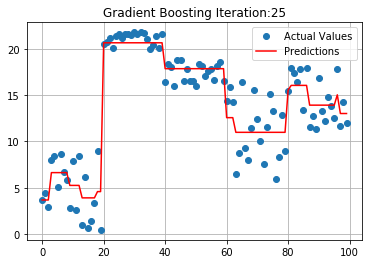

MSE: 3.875660242334807


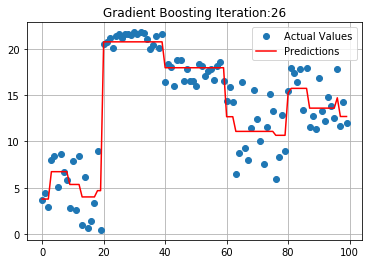

MSE: 3.8428716368524265


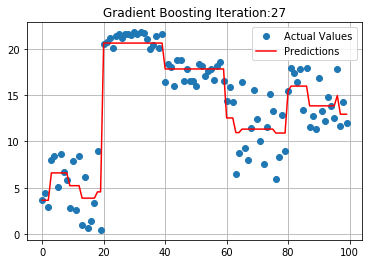

MSE: 3.810279715350377


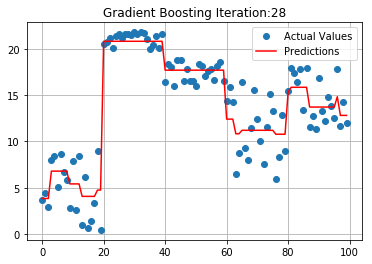

MSE: 3.785542308323943


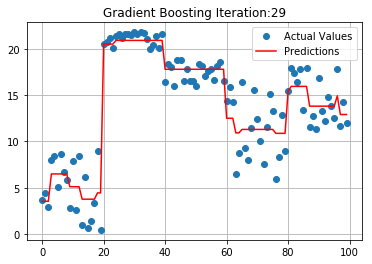

MSE: 3.7565575661627912


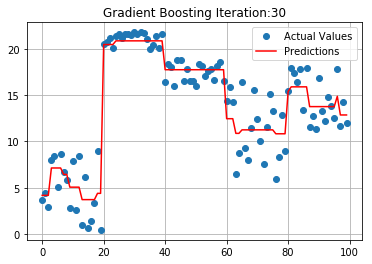

MSE: 3.7254896967165454


In [37]:
# 30 回繰り返す
for i in range(30):
    DT = DecisionTreeRegressor(max_depth=1)
    # 残差
    error = y - y_pred_i
    # 残差で学習
    DT = DT.fit(x, error)
    # 残差を予測
    y_pred_n = DT.predict(x)
    # 前回の予測値と残差の予測を加算し、今回の予測値にする
    y_pred_i = y_pred_n.reshape(-1, 1) + y_pred_i
    
    plt.plot(x, y, 'o', label='Actual Values')
    plt.plot(x, np.array(y_pred_i), 'r', label='Predictions')
    label = 'Gradient Boosting Iteration:' + str(i + 1)
    plt.title(label)
    plt.grid(True)
    plt.legend()
    plt.show()
    # 平均2乗和誤差
    print('MSE:', mean_squared_error(y, y_pred_i))